## Sea Performance Model

In [1]:
from math import ceil
lustre_rbw = lambda N, c, s, p, d_r, d : min(c*N, s*N, d_r*min(d, c*p))
lustre_wbw = lambda N, c, s, p, d_w, d : min(c*N, s*N, d_w*min(d, c*p))

M_l = (lambda
       D_r,
       D_w,
       N,
       c,
       s,
       p,
       d_r,
       d_w,
       d : ((D_r)/ lustre_rbw(N, c, s, p, d_r, d)) 
       + ((D_w)/ lustre_wbw(N, c, s, p, d_w, d))
)

D_cr = (lambda
        D_in,
        I: D_in*(I-1) # D_in = input data. All data is read from cache except during the first iteration (I = 1) where it's stored on Lustre
       )

D_cw = (lambda
        D_in,
        I: D_in*I)

M_c = (lambda
        D_in,
        I,
        c,
        C_r,
        C_w: (D_cr(D_in, I)/(c*C_r)) + (D_cw(D_in, I)/ (c*C_w))
        )

M_lc = (lambda
        D_I,
        N,
        c,
        s, 
        p,
        d_r,
        d,
        I,
        C_r,
        C_w: D_I / lustre_rbw(N, c, s, p, d_r, d) + M_c(D_I, I, c, C_r, C_w))


D_tr = (lambda
        D_m,
        c,
        t,
        p,
        F: min(D_m, max(c*(t-p*F), 0)))

D_tw = (lambda
        D_m,
        D_f,
        c,
        t,
        p,
        F: min(D_m + D_f, max(c*(t-p*F), 0)))


M_St = (lambda
        D_m,
        D_f,
        c,
        t,
        p,
        F,
        C_r,
        C_w: D_tr(D_m, c, t, p, F)/(c*C_r) + D_tw(D_m, D_f, c, t, p, F)/(c*C_w))

D_gr = (lambda
        D_m,
        c,
        t,
        p,
        F,
        g,
        r: min(D_m - D_tr(D_m, c, t, p, F), max(c*(g*r - p*F), 0)))

D_gw = (lambda
        D_m,
        D_f,
        c,
        t,
        p,
        F,
        g,
        r: min(D_m + D_f - D_tw(D_m, D_f, c, t, p, F), max(c*(g*r-p*F), 0)))

M_Sg = (lambda
        D_m,
        D_f,
        c,
        t,
        p,
        F,
        g,
        r,
        G_r,
        G_w: (D_gr(D_m, c, t, p, F, g, r) / (g*c*G_r)) + (D_gw(D_m, D_f, c, t, p, F, g, r) / (g*c*G_w)))

D_lr = (lambda
        D_m,
        c,
        t,
        p,
        f,
        g,
        r: D_m - D_gr(D_m, c, t, p, F, g, r) - D_tr(D_m, c, t, p, f))

D_lw = (lambda
        D_m,
        D_f,
        c,
        t,
        p,
        f,
        g,
        r: D_m + D_f - D_gw(D_m, D_f, c, t, p, f, g, r) - D_tw(D_m, D_f, c, t, p, f))

M_SL = (lambda
        D_I,
        N,
        c,
        s,
        p,
        d_r,
        d_w,
        d,
        D_m,
        D_f,
        t, 
        f,
        g,
        r: D_I/lustre_rbw(N, c, s, p, d_r, d) + D_lr(D_m, c, t, p, f, g, r)/lustre_rbw(N, c, s, p, d_r, d) + D_lw(D_m, D_f, c, t, p, f, g, r)/lustre_wbw(N, c, s, p, d_w, d))

M_Sc = (lambda
        D_I,
        N,
        c,
        s,
        p,
        d_r,
        d,
        D_m,
        C_w,
        C_r,
        D_f: D_I/lustre_rbw(N, c, s, p, d_r, d) + D_m/(c*C_r) + (D_m + D_f)/(c*C_w))

M_S = (lambda D_I, N, c, s, p, d_r, d_w, d, D_m, D_f, t, f, g, r, G_r, G_w, C_r, C_w :
       M_St(D_m, D_f, d, t, p, F, C_r, C_w) + 
       M_Sg(D_m, D_f, c, t, p, F, g, r, G_r, G_w) +
       M_SL(D_I,N,c,s,p,d_r,d_w,d,D_m,D_f,t,f,g,r))

In [2]:
F = 617
n_f = 1000
I = 10
D_in = F * n_f
D_r = F * n_f * I
D_w = D_r
D_m = F * n_f * (I - 1)
D_f = F * n_f
N = 25 * 128
c = 5
s = 4
p = 6
d_r = 200
d_w = 191
d = 44
C_r = 6676.48
C_w = 2560 * 16
t = 126 * 1024
g = 6
G_r = 500
G_w = 426
r = 447 * 1024

def reset_params():
    global F, n_f, I, D_in, D_r, D_w, D_m, D_f, N, c, s, p, d_r, d_w, d, C_r, C_w, t, g, r, G_r, G_w
    F = 617
    n_f = 1000
    D_in = F * n_f
    N = 25 * 128
    c = 5
    s = 4
    p = 6
    d = 44
    d_r = 1381 / s #200
    d_w = 121
    C_r = 6676.48
    C_w = 2560 * 16
    t = 126 * 1024
    g = 6
    G_r = 500
    G_w = 426
    r = 447 * 1024

In [3]:
1381/s

345.25

### Model evaluation - Number of nodes

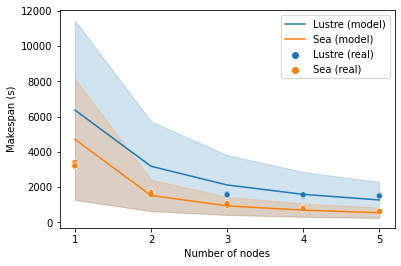

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

bw = range(128, 100*128, 128)
gbps = [b/128 for b in bw]

I=10
reset_params()
D_r = F * n_f * I
D_w = D_r
D_m = F * n_f * (I - 1)
D_f = F * n_f

nodes = list(range(1,6))


lustre_npc = [M_l(D_r, D_w, N, nc, s, p, d_r, d_w, d) for nc in nodes]
lustre_pc = [M_Sc(D_in, N, nc, s, p, d_r, d, D_m, C_w, C_r, D_f) for nc in nodes]
sea_npc = [M_S(D_in, N, nc, s, p, d_r, d_w, d, D_m, D_f, t, F, g, r, G_r, G_w, C_r, C_w) for nc in nodes]

df_lustre = pd.read_csv("../results_new/exp_nodes.out")#_lustre.out")
df_lustre["nodes"] = df_lustre["experiment"].apply(lambda row: int(row.split('n_')[0].split("_")[-1]))
df_lustre["fs"] = df_lustre["experiment"].apply((lambda row: row.split("_")[0] if "lustre" in row else row.split("_")[1]))
df_lustre.loc[df_lustre["fs"] == "mem", "fs"] = "Sea (real)"
df_lustre.loc[df_lustre["fs"] == "lustre", "fs"] = "Lustre (real)"
df_lustre = df_lustre.sort_values(by=["fs", "nodes"])


sns.lineplot(x=nodes+nodes, y=lustre_pc + lustre_npc, label="Lustre (model)")
sns.lineplot(x=nodes+nodes, y=lustre_pc + sea_npc, label="Sea (model)")

sns.scatterplot(data=df_lustre, x="nodes", y="runtime", hue="fs")
plt.xlabel("Number of nodes")
plt.ylabel("Makespan (s)")
plt.legend(title=None)
plt.xticks(nodes)
plt.savefig("../../../paper/sea-comp/figures/nodes.pdf")
plt.show()

df_s = df_lustre[df_lustre["fs"] == "Sea (real)"] \
    .sort_values("nodes") \
    .reset_index() \
    .groupby("nodes") \
    .mean()
df_l = df_lustre[df_lustre["fs"] == "Lustre (real)"] \
    .sort_values("nodes") \
    .reset_index() \
    .groupby("nodes") \
    .mean()
#df_l / df_s#, df_l, df_s

### Model evaluation - Number of disks

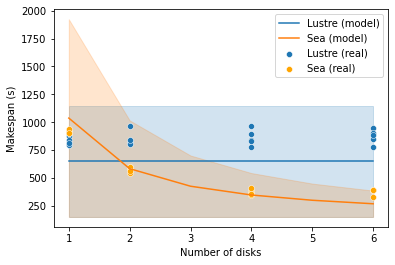

,index,repetition,runtime,disk_files,total_flush
disks,,,,,
1,45.588554,428.53241,0.935252,inf,0.533133
2,44.178599,428.53241,1.491713,inf,0.857065
4,46.579610,428.53241,2.298998,inf,0.857065
6,42.012981,428.53241,2.275406,inf,0.857065


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nodes = 5
disks = list(range(1, 7))

I= 5
reset_params()
D_r = F * n_f * I
D_w = D_r
D_m = F * n_f * (I - 1)
D_f = F * n_f

lustre_npc = [M_l(D_r, D_w, N, nodes, s, p, d_r, d_w, d) for nd in disks]
lustre_pc = [M_Sc(D_in, N, nodes, s, p, d_r, d, D_m, C_w, C_r, D_f) for nd in disks]
sea_npc = [M_S(D_in, N, nodes, s, p, d_r, d_w, d, D_m, D_f, t, F, nd, r, G_r, G_w, C_r, C_w) for nd in disks]

df_lustre = pd.read_csv("../results_new/exp_dlustre.out")
df_lustre["disks"] = df_lustre["experiment"].apply(lambda name: int(name.split("d_")[0].split("_")[-1]))
df_lustre["fs"] = df_lustre["experiment"].apply(lambda name: name.split("_")[0])
df_lustre = df_lustre.sort_values(by=['fs','disks'])


df_l = pd.read_csv("../results_new/exp_disks.out")
df_l["disks"] = df_l["experiment"].apply(lambda name: int(name.split("d_")[0].split("_")[-1]))
df_l["fs"] = df_l["experiment"].apply(lambda name: name.split("_")[0])
df_l = df_l.sort_values(by=['fs','disks'])

df_l = df_l[~df_l["experiment"].str.contains("cp")]
sns.lineplot(x=disks + disks, y=lustre_npc + lustre_pc, label="Lustre (model)")
sns.lineplot(x=disks+disks, y=sea_npc + lustre_pc, label="Sea (model)")
sns.scatterplot(data=df_lustre, x="disks", y="runtime", label="Lustre (real)")
sns.scatterplot(data=df_l, x="disks", y="runtime", color="orange", label="Sea (real)")
plt.xlabel("Number of disks")
plt.ylabel("Makespan (s)")
plt.xticks(disks)
plt.savefig("../../../paper/sea-comp/figures/disks.pdf")
plt.show()

df_s = df_l\
    .sort_values("disks") \
    .reset_index() \
    .groupby("disks") \
    .mean()

df_lustre["runtime"].mean() / df_s

### Model evaluation - Number of iterations (NEEDS TO BE REDONE)

,index,repetition,runtime,disk_files,total_flush
iterations,,,,,
1,1.120567,1.0,0.933250,NaN,NaN
5,1.073826,1.0,1.992351,NaN,NaN
10,0.920530,1.0,2.600868,NaN,NaN
15,1.085106,1.0,2.308741,NaN,NaN


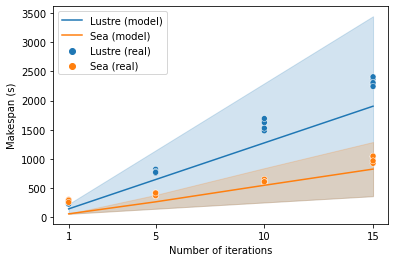

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

n_iterations = [1, 5, 10, 15]

I=5
reset_params()

lustre_npc = [M_l(F*n_f*ni, F*n_f*ni, N, c, s, p, d_r, d_w, d) for ni in n_iterations]
lustre_pc = [M_Sc(D_in, N, c, s, p, d_r, d, F*n_f*(ni-1), C_w, C_r, F*n_f) for ni in n_iterations]
sea_npc = [M_S(D_in, N, c, s, p, d_r, d_w, d, F*n_f*(ni-1), F*n_f, t, F, g, r, G_r, G_w, C_r, C_w) for ni in n_iterations]

df_lustre = pd.read_csv("../results_new/exp_iterations.out")
df_lustre["iterations"] = df_lustre["experiment"].apply(lambda row: int(row.split("_")[-1].strip("i")))
df_lustre["fs"] = df_lustre["experiment"].apply((lambda row: row.split("_")[0]))
df_lustre = df_lustre[~df_lustre["fs"].str.contains("cp")]
df_lustre.loc[df_lustre["fs"] == "seamem", "fs"] = "Sea (real)"
df_lustre.loc[df_lustre["fs"] == "lustre", "fs"] = "Lustre (real)"
df_lustre = df_lustre.sort_values(by="fs").rename(columns={"fs": "File system"})

its = n_iterations
sns.lineplot(x=its+its, y=lustre_pc+lustre_npc, label="Lustre (model)")
sns.lineplot(x=its+its, y=lustre_pc+sea_npc, label="Sea (model)")

sns.scatterplot(data=df_lustre, x="iterations", y="runtime", hue="File system")
plt.xlabel("Number of iterations")
plt.ylabel("Makespan (s)")
plt.xticks(n_iterations)
plt.legend(loc="upper left", title=None)
plt.savefig("../../../paper/sea-comp/figures/iterations.pdf")

df_s = df_lustre[df_lustre["File system"] == "Sea (real)"] \
    .sort_values("iterations") \
    .reset_index() \
    .groupby("iterations") \
    .mean()
df_l = df_lustre[df_lustre["File system"] == "Lustre (real)"] \
    .sort_values("iterations") \
    .reset_index() \
    .groupby("iterations") \
    .mean()
df_l / df_s#, df_l, df_s_

### Model evaluation - Number of threads

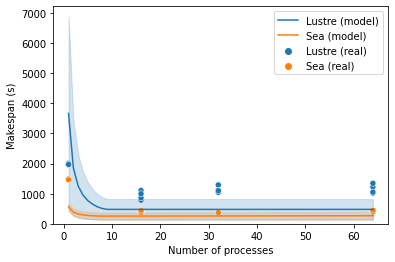

,index,repetition,runtime,disk_files,total_flush
threads,,,,,
1,34.50,2.5,1990.745063,0.0,5000.0
16,31.75,2.5,937.373873,0.0,5000.0
32,38.00,2.5,1140.881897,0.0,5000.0
64,34.25,2.5,1160.959668,0.0,5000.0


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

n_process = list(range(1, 65))

I = 5
reset_params()

D_r = F * n_f * I
D_w = D_r
D_m = F * n_f * (I - 1)
D_f = F * n_f

lustre_npc = [M_l(D_r, D_w, N, c, s, np, d_r, d_w, d) for np in n_process]
lustre_pc = [M_Sc(D_in, N, c, s, np, d_r, d, D_m, C_w, C_r, D_f) for np in n_process]
sea_npc = [M_S(D_in, N, c, s, np, d_r, d_w, d, D_m, D_f, t, F, g, r, G_r, G_w, C_r, C_w) for np in n_process]

df_lustre = pd.read_csv("../results_new/exp_threads.out")
df_lustre["fs"] = df_lustre["experiment"].apply(lambda x: "_".join(x.split("_")[0:2]) if "sea" in x else x.split("_")[0])
df_lustre = df_lustre[df_lustre["fs"] != "sea_cp"]
df_lustre["threads"] = df_lustre["experiment"].apply(lambda row: int(row.split("t_")[0].split("_")[-1]))
df_lustre = df_lustre.sort_values(by=["fs", "threads"])
df_lustre = df_lustre[df_lustre["repetition"] > 0]
df_lustre = df_lustre[df_lustre["runtime"] < 3000]

sns.lineplot(x=n_process+n_process, y=lustre_pc + lustre_npc, label="Lustre (model)")
sns.lineplot(x=n_process+n_process, y=lustre_pc + sea_npc, label="Sea (model)")

df_lustre.loc[df_lustre["fs"] == "sea_mem", "fs"] = "Sea (real)"
df_lustre.loc[df_lustre["fs"] == "lustre", "fs"] = "Lustre (real)"
df_lustre = df_lustre.rename(columns={"fs": "File system"})
sns.scatterplot(data=df_lustre, x="threads", y="runtime", hue="File system")

plt.xlabel("Number of processes")
plt.ylabel("Makespan (s)")
plt.ylim(0)
plt.legend(title=None)
plt.savefig("../../../paper/sea-comp/figures/threads.pdf")
plt.show()

df_s = df_lustre[df_lustre["File system"] == "Sea (real)"] \
    .sort_values("threads") \
    .reset_index() \
    .groupby("threads") \
    .mean()
df_l = df_lustre[df_lustre["File system"] == "Lustre (real)"] \
    .sort_values("threads") \
    .reset_index() \
    .groupby("threads") \
    .mean()
df_l

,repetition,Runtime,disk_files,total_flush,iterations
Experiment,,,,,
Lustre,2.0,1164.939644,0.0,5000.0,5.0
Sea:flush-all,2.0,1487.539792,0.0,5000.0,5.0
Sea:in-memory,2.0,423.823263,0.0,1000.0,5.0


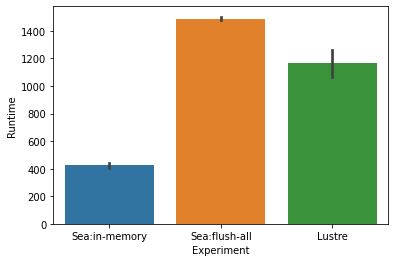

In [8]:
df_lustre = pd.read_csv("../results_new/exp_threads.out")
df_lustre["iterations"] = df_lustre["experiment"].apply(lambda row: int(row.split("_")[-1].strip("i")))
df_lustre["fs"] = df_lustre["experiment"].apply((lambda row: row.split("_")[0]))
df_lustre["threads"] = df_lustre["experiment"].apply((lambda row: row.split("_")[3 if "sea" in row else 2]))
df_lustre["experiment"] = df_lustre["experiment"].apply((lambda row: "Sea:flush-all" if "cp" in row else "Sea:in-memory" if "mem" in row  else "Lustre"))

df_lustre = df_lustre.rename(columns={"experiment":"Experiment", "runtime": "Runtime"})
order = ["Sea:in-memory", "Sea:flush-all", "Lustre"]

sns.barplot(x="Experiment", y="Runtime", data=df_lustre[df_lustre["threads"] == "64t"].set_index("Experiment").loc[order].reset_index())
plt.savefig("../../../paper/sea-comp/figures/flushall.pdf")
df_lustre[df_lustre["threads"] == "64t"].groupby("Experiment").mean()